In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dt_clf = DecisionTreeClassifier()

iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, 
                                                   test_size=0.2)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [3]:
from sklearn.tree import export_graphviz

export_graphviz(dt_clf, out_file='tree.dot', class_names = iris_data.target_names,
                feature_names=iris_data.feature_names, impurity=True, filled=True)

In [5]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


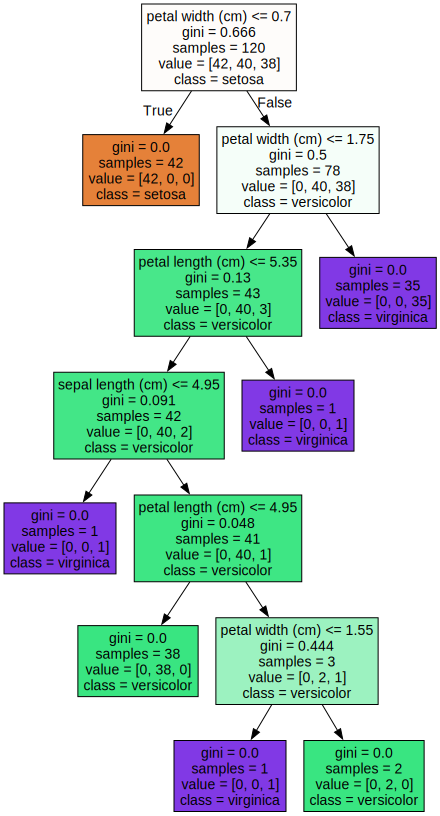

In [7]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Feature importances: [0.023 0.    0.03  0.947]
sepal length (cm) : 0.023
sepal width (cm) : 0.000
petal length (cm) : 0.030
petal width (cm) : 0.947


<Axes: >

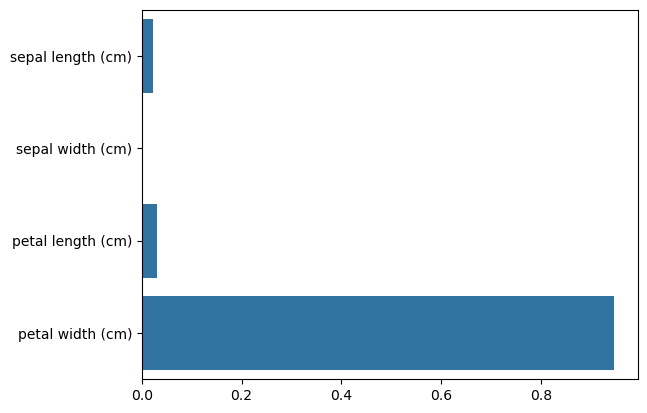

In [9]:
import seaborn as sns
import numpy as np
%matplotlib inline

# feature importance 추출
print("Feature importances: {0}".format(np.round(dt_clf.feature_importances_,3)))

for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print("{0} : {1:.3f}".format(name, value))

sns.barplot(x=dt_clf.feature_importances_, y=iris_data.feature_names) # petal width의 feature 중요도가 가장 높음!

# 결정 트리 과적합 (Overfitting)
* make_classification() :분류를 위한 테스트용 데이터를 쉽게 만들게 해주는 함수

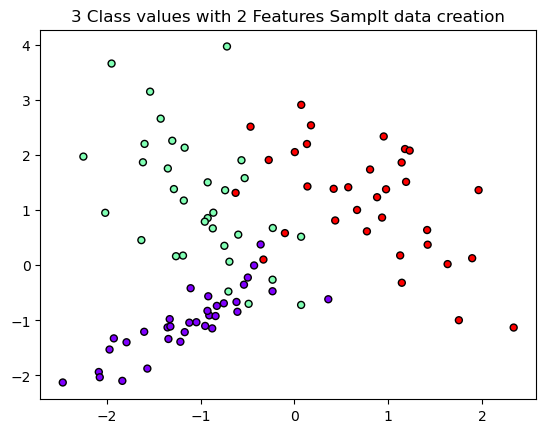

In [11]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("3 Class values with 2 Features Samplt data creation")

X_features, y_labels = make_classification(n_features=2, n_redundant=0, n_informative=2,
                                          n_classes=3, n_clusters_per_class=1)
plt.scatter(X_features[:, 0], X_features[:, 1], marker='o', c=y_labels, s=25, cmap='rainbow', edgecolor='k')

In [13]:
# 경계를 시각화하는 함수
import numpy as np

def visualize_boundary(model, X, y):
    fig, ax = plt.subplots()

    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
              clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start, xlim_end = ax.get_xlim()
    ylim_start, ylim_end = ax.get_ylim()

    model.fit(X,y)
    xx, yy = np.meshgrid(np.linspace(xlim_start, xlim_end, num=200), np.linspace(ylim_start, ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                          levels=np.arange(n_classes + 1) - 0.5,
                          cmap='rainbow', clim=(y.min(), y.max()),
                          zorder=1)

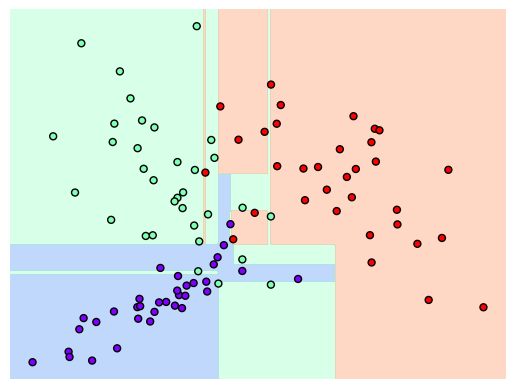

In [15]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier().fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

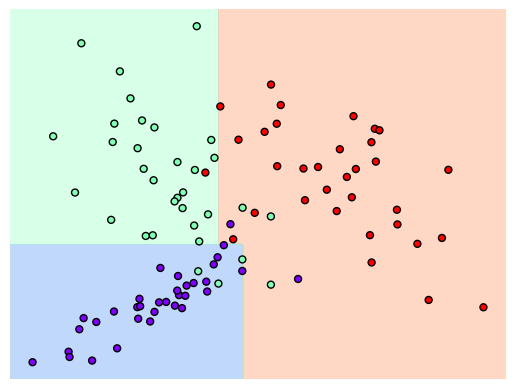

In [17]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=6).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

# 결정 트리 실습 - Human Activity Recognition

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

feature_name_df = pd.read_csv(r"C:\Users\HOME\Desktop\human_activity\features.txt",
                              sep=r'\s+', header=None, names=['column_index', 'column_name'])
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print("10개만 추출: ", feature_name[:10])

10개만 추출:  ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [5]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [7]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(
        data=old_feature_name_df.groupby('column_name').cumcount(),
        columns=['dup_cnt']
    ).reset_index()

    new_feature_name_df = pd.merge(
        old_feature_name_df.reset_index(), feature_dup_df, how='outer'
    )

    # iloc 사용해서 FutureWarning 방지
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(
        lambda x: x.iloc[0] + '_' + str(x.iloc[1]) if x.iloc[1] > 0 else x.iloc[0],
        axis=1
    )

    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [9]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv(r"C:\Users\HOME\Desktop\human_activity\features.txt",sep=r'\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv(r"C:\Users\HOME\Desktop\human_activity\train\X_train.txt",sep=r'\s+', names=feature_name )
    X_test = pd.read_csv(r"C:\Users\HOME\Desktop\human_activity\test\X_test.txt",sep=r'\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv(r"C:\Users\HOME\Desktop\human_activity\train\y_train.txt",sep=r'\s+',header=None,names=['action'])
    y_test = pd.read_csv(r"C:\Users\HOME\Desktop\human_activity\test\y_test.txt",sep=r'\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [11]:
print('## 학습 피처 데이터셋 info()')
print(X_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [13]:
print(y_train['action'].value_counts())

action
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 예제 반복 시 마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train , y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 156, 'splitter': 'best'}


In [17]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [ 6, 8 ,10, 12, 16 ,20, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 )
grid_cv.fit(X_train , y_train)
print('GridSearchCV 최고 평균 정확도 수치:{0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치:0.8513
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16}


In [18]:
# GridSearchCV객체의 cv_results_ 속성을 DataFrame으로 생성. 
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트(Evaluation)셋, 학습 데이터 셋의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


In [ ]:
max_depths = [ 6, 8 ,10, 12, 16 ,20, 24]
# max_depth 값을 변화 시키면서 그때마다 학습과 테스트 셋에서의 예측 성능 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
    dt_clf.fit(X_train , y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test , pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth , accuracy))

In [ ]:
params = {
    'max_depth' : [ 8 , 12, 16 ,20], 
    'min_samples_split' : [16, 24],
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 )
grid_cv.fit(X_train , y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

In [ ]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred1)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))


In [ ]:

import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_
# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns  )
# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()
